#### Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.features.concurrency import *
from FinancialMachineLearning.utils import multiprocess
import warnings
warnings.filterwarnings('ignore')

In [2]:
dollar = pd.read_csv('../../Data/dollar_IVEfuture.csv', index_col = 0, parse_dates = True)
dollar = dollar[~dollar.index.duplicated(keep = 'first')]
dollar

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:34,80,50.79,51.070,50.7100,51.07,20044,13264,80,1.020027e+06
2009-09-28 09:52:47,142,51.07,51.148,51.0500,51.13,21024,19774,62,1.073986e+06
2009-09-28 09:54:38,201,51.14,51.150,51.1290,51.13,19951,6951,59,1.020145e+06
2009-09-28 09:55:26,243,51.13,51.150,51.1300,51.14,19652,18052,42,1.004999e+06
2009-09-28 10:02:48,339,51.14,51.260,51.0800,51.25,19943,11354,96,1.020512e+06
...,...,...,...,...,...,...,...,...,...
2023-09-14 15:54:32,10930083,162.98,163.060,162.9654,162.98,6186,3983,39,1.008408e+06
2023-09-14 15:59:20,10930131,162.99,163.040,162.9299,163.04,7158,4629,48,1.166735e+06
2023-09-14 15:59:39,10930171,163.04,163.050,162.9900,163.00,6316,3266,40,1.029639e+06


#### EWMA volatility

In [3]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(dollar.close, lookback = 100)

#### CUSUM Filtering

In [4]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(dollar.close, threshold = vol.mean())

#### add Vertical berrier

In [5]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, dollar['close'], num_days = 1)

#### Triple Barrier Methods

In [6]:
triple_barrier_events = get_events(
    close = dollar['close'],
    t_events = cusum_events[34:],
    pt_sl = [1, 1],
    target = vol,
    min_ret = 0.01,
    num_threads = 1,
    vertical_barrier_times = vertical_barrier,
    side_prediction = None
)
triple_barrier_events

,t1,trgt,pt,sl
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1
2009-10-02 09:53:14,2009-10-05 09:35:17,0.010379,1,1
2009-10-02 10:01:56,2009-10-05 09:35:17,0.010430,1,1
2009-10-02 10:09:13,2009-10-05 09:35:17,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.010701,1,1
2023-05-08 15:16:37,2023-05-09 15:24:47,0.010595,1,1
2023-05-08 15:36:39,2023-05-09 15:40:39,0.010387,1,1
2023-05-08 15:47:11,2023-05-09 15:48:38,0.010283,1,1


#### Concurrency

In [7]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = dollar.close.index, label_endtime = triple_barrier_events['t1'])

In [8]:
num_conc_events = num_conc_events.reindex(dollar.close.index).fillna(0)

#### Uniqueness

In [9]:
avg_unique = multiprocess.mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

2009-10-02 09:31:33    0.275361
2009-10-02 09:44:59    0.202897
2009-10-02 09:53:14    0.135099
2009-10-02 10:01:56    0.130016
2009-10-02 10:09:13    0.126859
                         ...   
2023-05-08 15:16:20    0.073810
2023-05-08 15:16:37    0.074945
2023-05-08 15:36:39    0.107179
2023-05-08 15:47:11    0.124807
2023-05-08 15:54:13    0.161731
Length: 30053, dtype: float64

#### Lambda

In [10]:
from FinancialMachineLearning.features.microstructure import *

lambda_feature = BarbasedLambda(close = dollar['close'],
                                volume = dollar['volume'],
                                dollar_volume = dollar['cum_dollar_value'])

In [11]:
kyle_lambda = lambda_feature.kyle()
#kyle_lambda.index = data1.index
kyle_lambda.names = ['Kyle']
kyle_lambda.dropna()

date_time
2009-09-28 12:28:20    0.000001
2009-09-28 13:06:05    0.000001
2009-09-28 13:27:13    0.000001
2009-09-28 13:43:34    0.000002
2009-09-28 13:57:04    0.000001
                         ...   
2023-09-14 15:54:32    0.000008
2023-09-14 15:59:20    0.000008
2023-09-14 15:59:39    0.000009
2023-09-14 15:59:59    0.000009
2023-09-14 16:00:00    0.000009
Length: 215813, dtype: float64

In [12]:
amihud_lambda = lambda_feature.amihud()
#amihud_lambda.index = data1.index
amihud_lambda.names = ['Aminud']
amihud_lambda.dropna()

date_time
2009-09-28 12:28:20    5.233728e-10
2009-09-28 13:06:05    5.074193e-10
2009-09-28 13:27:13    5.549078e-10
2009-09-28 13:43:34    6.017363e-10
2009-09-28 13:57:04    5.561291e-10
                           ...     
2023-09-14 15:54:32    3.182107e-10
2023-09-14 15:59:20    3.198206e-10
2023-09-14 15:59:39    3.286745e-10
2023-09-14 15:59:59    3.331754e-10
2023-09-14 16:00:00    3.320301e-10
Length: 215813, dtype: float64

In [13]:
hasbrouck_lambda = lambda_feature.hasbrouck()
#hasbrouck_lambda.index = data1.index
hasbrouck_lambda.columns = ['Hasbrouck']
hasbrouck_lambda.dropna()

date_time
2009-09-28 12:28:20    5.297349e-07
2009-09-28 13:06:05    5.118725e-07
2009-09-28 13:27:13    5.599020e-07
2009-09-28 13:43:34    6.083900e-07
2009-09-28 13:57:04    5.618634e-07
                           ...     
2023-09-14 15:54:32    3.372095e-07
2023-09-14 15:59:20    3.400610e-07
2023-09-14 15:59:39    3.490828e-07
2023-09-14 15:59:59    3.536317e-07
2023-09-14 16:00:00    3.509756e-07
Length: 215813, dtype: float64

#### VPIN

In [14]:
from FinancialMachineLearning.barsampling.bar_feature import BarFeature
def buy_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()

def sell_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()
    
buy_volume_feature = BarFeature(name='buy_volume', function=buy_volume)
sell_volume_feature = BarFeature(name='sell_volume', function=sell_volume)

In [15]:
bars = vpin_volume_bars('../../Data/IVEfuture.csv', additional_features = [buy_volume_feature, sell_volume_feature])

Reading data in batches:
Batch number: 0
Returning bars 


In [16]:
bars

,date_time,open,high,low,close,volume,buy_volume,sell_volume
0,09/28/2009 09:47:22,50.790,51.0700,50.7100,51.06,28244,21464,6780
1,09/28/2009 09:54:36,51.060,51.1500,51.0600,51.13,28575,16425,12150
2,09/28/2009 09:57:17,51.130,51.1500,51.0900,51.09,28341,22852,5489
3,09/28/2009 10:02:52,51.100,51.2600,51.0800,51.25,28654,23554,5100
4,09/28/2009 10:10:21,51.260,51.2900,51.1900,51.29,28319,16784,11535
...,...,...,...,...,...,...,...,...
82884,09/14/2023 13:11:37,162.560,162.9950,162.5500,162.98,28297,13571,14726
82885,09/14/2023 14:34:34,162.972,163.0699,162.8700,162.94,28330,11073,17257
82886,09/14/2023 15:36:28,162.930,163.2150,162.8900,162.99,58926,40704,18222
82887,09/14/2023 15:59:23,162.980,163.0600,162.9299,163.05,28291,19218,9073


In [17]:
vol_thres = 10000
vpin_series = vpin(bars['volume'], bars['buy_volume'], window = 5)

In [18]:
vpin_series = pd.DataFrame(vpin_series, index = pd.to_datetime(bars.date_time))

#### Corwin Schultz spread

In [19]:
corwin_schultz = CorwinSchultz(dollar['high'], dollar['low'])

In [20]:
spread = corwin_schultz.corwin_schultz_estimator(window = 20)
spread.dropna()

date_time
2009-09-28 12:28:20    0.001863
2009-09-28 13:06:05    0.000549
2009-09-28 13:27:13    0.000409
2009-09-28 13:43:34    0.000000
2009-09-28 13:57:04    0.000000
                         ...   
2023-09-14 15:54:32    0.001171
2023-09-14 15:59:20    0.000698
2023-09-14 15:59:39    0.000856
2023-09-14 15:59:59    0.001435
2023-09-14 16:00:00    0.002154
Name: Spread, Length: 215813, dtype: float64

#### Fractionally differenciated Features

In [21]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
frac_dollar = FractionalDifferentiatedFeatures.fracDiff_FFD(dollar.iloc[:,4:5], 0.2)

In [22]:
frac_dollar

,close
2010-04-29 10:26:57,10.476812
2010-04-29 11:09:15,10.507715
2010-04-29 11:26:03,10.464420
2010-04-29 11:34:28,10.488812
2010-04-29 11:44:01,10.540226
...,...
2023-09-14 15:54:32,28.022345
2023-09-14 15:59:20,28.081668
2023-09-14 15:59:39,28.025730
2023-09-14 15:59:59,28.004278


#### Labeling

In [23]:
labels = meta_labeling(triple_barrier_events, dollar['close'])
labels

,ret,trgt,bin
2009-10-02 09:31:33,0.011168,0.010011,1
2009-10-02 09:44:59,0.010552,0.010268,1
2009-10-02 09:53:14,0.006066,0.010379,0
2009-10-02 10:01:56,0.008308,0.010430,0
2009-10-02 10:09:13,0.007216,0.010453,0
...,...,...,...
2023-05-08 15:16:20,-0.002736,0.010701,0
2023-05-08 15:16:37,-0.002301,0.010595,0
2023-05-08 15:36:39,-0.002368,0.010387,0
2023-05-08 15:47:11,-0.003483,0.010283,0


In [24]:
matrix = pd.DataFrame()
matrix = pd.concat([dollar.close, frac_dollar, 
                    vol, num_conc_events, avg_unique, spread, 
                    kyle_lambda, amihud_lambda, hasbrouck_lambda, 
                    labels['bin']], axis = 1)
matrix.columns = ['Price','Fracdiff','Volatility','Concurrency','Uniqueness','CorwinSchultz','Kyle','Amihud','Hasbrouck','Side']
matrix = matrix.dropna()
matrix

,Price,Fracdiff,Volatility,Concurrency,Uniqueness,CorwinSchultz,Kyle,Amihud,Hasbrouck,Side
2010-04-29 10:26:57,58.2801,10.476812,0.010964,15.0,0.104609,0.002505,0.000005,1.465374e-09,1.483819e-06,0.0
2010-04-29 11:09:15,58.3600,10.507715,0.011247,5.0,0.101340,0.000000,0.000005,1.444967e-09,1.463203e-06,0.0
2010-04-29 11:34:28,58.4100,10.488812,0.011638,5.0,0.086407,0.006100,0.000005,1.363788e-09,1.381967e-06,0.0
2010-04-29 11:44:01,58.4900,10.540226,0.011979,6.0,0.080429,0.004628,0.000004,1.333476e-09,1.348967e-06,0.0
2010-04-29 12:00:06,58.4498,10.465450,0.012262,7.0,0.074427,0.006678,0.000004,1.333155e-09,1.348640e-06,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,26.030479,0.010701,22.0,0.073810,0.002960,0.000020,8.639489e-10,9.057686e-07,0.0
2023-05-08 15:16:37,152.0900,25.963539,0.010595,23.0,0.074945,0.003382,0.000018,7.985690e-10,8.333525e-07,0.0
2023-05-08 15:36:39,152.0701,25.952489,0.010387,24.0,0.107179,0.002875,0.000018,7.770907e-10,8.105908e-07,0.0
2023-05-08 15:47:11,152.1800,26.065165,0.010283,25.0,0.124807,0.002256,0.000018,7.929681e-10,8.267172e-07,0.0


#### Meta Labeling

In [25]:
triple_barrier_events['side'] = labels.bin
triple_barrier_events

,t1,trgt,pt,sl,side
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1,1
2009-10-02 09:53:14,2009-10-05 09:35:17,0.010379,1,1,0
2009-10-02 10:01:56,2009-10-05 09:35:17,0.010430,1,1,0
2009-10-02 10:09:13,2009-10-05 09:35:17,0.010453,1,1,0
...,...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.010701,1,1,0
2023-05-08 15:16:37,2023-05-09 15:24:47,0.010595,1,1,0
2023-05-08 15:36:39,2023-05-09 15:40:39,0.010387,1,1,0
2023-05-08 15:47:11,2023-05-09 15:48:38,0.010283,1,1,0


In [26]:
meta_labels = meta_labeling(triple_barrier_events, dollar['close'])
meta_labels

,ret,trgt,bin,side
2009-10-02 09:31:33,0.011168,0.010011,1,1
2009-10-02 09:44:59,0.010552,0.010268,1,1
2009-10-02 09:53:14,0.000000,0.010379,0,0
2009-10-02 10:01:56,0.000000,0.010430,0,0
2009-10-02 10:09:13,0.000000,0.010453,0,0
...,...,...,...,...
2023-05-08 15:16:20,0.000000,0.010701,0,0
2023-05-08 15:16:37,0.000000,0.010595,0,0
2023-05-08 15:36:39,0.000000,0.010387,0,0
2023-05-08 15:47:11,0.000000,0.010283,0,0


In [27]:
matrix['label'] = meta_labels['bin']
matrix

,Price,Fracdiff,Volatility,Concurrency,Uniqueness,CorwinSchultz,Kyle,Amihud,Hasbrouck,Side,label
2010-04-29 10:26:57,58.2801,10.476812,0.010964,15.0,0.104609,0.002505,0.000005,1.465374e-09,1.483819e-06,0.0,0
2010-04-29 11:09:15,58.3600,10.507715,0.011247,5.0,0.101340,0.000000,0.000005,1.444967e-09,1.463203e-06,0.0,0
2010-04-29 11:34:28,58.4100,10.488812,0.011638,5.0,0.086407,0.006100,0.000005,1.363788e-09,1.381967e-06,0.0,0
2010-04-29 11:44:01,58.4900,10.540226,0.011979,6.0,0.080429,0.004628,0.000004,1.333476e-09,1.348967e-06,0.0,0
2010-04-29 12:00:06,58.4498,10.465450,0.012262,7.0,0.074427,0.006678,0.000004,1.333155e-09,1.348640e-06,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,26.030479,0.010701,22.0,0.073810,0.002960,0.000020,8.639489e-10,9.057686e-07,0.0,0
2023-05-08 15:16:37,152.0900,25.963539,0.010595,23.0,0.074945,0.003382,0.000018,7.985690e-10,8.333525e-07,0.0,0
2023-05-08 15:36:39,152.0701,25.952489,0.010387,24.0,0.107179,0.002875,0.000018,7.770907e-10,8.105908e-07,0.0,0
2023-05-08 15:47:11,152.1800,26.065165,0.010283,25.0,0.124807,0.002256,0.000018,7.929681e-10,8.267172e-07,0.0,0


#### Meta Model

In [28]:
from sklearn.model_selection import train_test_split
X = matrix.iloc[:,[0,1,2,3,5,6,8]]
y = matrix.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000,
                            criterion = 'entropy', 
                            random_state = 42,
                            class_weight = 'balanced_subsample', 
                            ccp_alpha = 0.001,
                            min_weight_fraction_leaf = 0.05,
                            max_samples = matrix['Uniqueness'].mean(),
                            max_features = 20)
model = rf.fit(X_train, y_train)

#### Feature importances

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from FinancialMachineLearning.machine_learning.cross_validation import PurgedKFold, ml_cross_val_score

from FinancialMachineLearning.feature_importance.importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    single_feature_importance,
    plot_feature_importance
)

def feature_importances(X, cont, method, allow_masking_effects = False, n_splits = 10):
    max_features = None if allow_masking_effects else 1
    clf = DecisionTreeClassifier(
        criterion='entropy', max_features=max_features, class_weight='balanced', min_weight_fraction_leaf=0.0
    )
    clf = BaggingClassifier(
        base_estimator=clf, n_estimators=1000, max_features=1.0, max_samples=1.0, oob_score=True, n_jobs=-1
    )
    fit = clf.fit(X, cont['bin'])
    oob_score = fit.oob_score_

    cv_gen = PurgedKFold(n_splits=n_splits, samples_info_sets=cont['t1'])
    oos_score = ml_cross_val_score(clf, X, cont['bin'], cv_gen=cv_gen, scoring=accuracy_score).mean()

    if method == 'MDI':
        imp = mean_decrease_impurity(fit, X.columns)
    elif method == 'MDA':
        imp = mean_decrease_accuracy(clf, X, cont['bin'], cv_gen, scoring=accuracy_score)
    elif method == 'SFI':
        imp = single_feature_importance(clf, X, cont['bin'], cv_gen, scoring=accuracy_score)
    
    return imp, oob_score, oos_score


def test_data_func(X, cont, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    for method in methods:
        feature_imp, oob_score, oos_score = feature_importances(X, cont, method, allow_masking_effects)
        plot_feature_importance(
            feature_imp, oob_score=oob_score, oos_score=oos_score,
            save_fig = False
        )


In [31]:
cont = pd.concat([matrix['label'][:20590], triple_barrier_events[-29415:][:20590]['trgt'], triple_barrier_events[-29415:][:20590]['t1']], axis = 1)
cont.columns = ['bin','w','t1']
cont

,bin,w,t1
2010-04-29 10:26:57,0,0.010964,2010-04-30 10:32:44
2010-04-29 11:09:15,0,0.011247,2010-04-30 11:27:17
2010-04-29 11:34:28,0,0.011638,2010-04-30 11:51:36
2010-04-29 11:44:01,0,0.011979,2010-04-30 11:51:36
2010-04-29 12:00:06,0,0.012262,2010-04-30 12:12:31
...,...,...,...
2020-09-03 13:03:18,1,0.011484,2020-09-04 11:27:01
2020-09-03 13:04:35,1,0.011690,2020-09-04 09:44:44
2020-09-03 13:11:31,1,0.011758,2020-09-04 11:27:01
2020-09-03 13:17:19,1,0.011821,2020-09-04 11:27:01


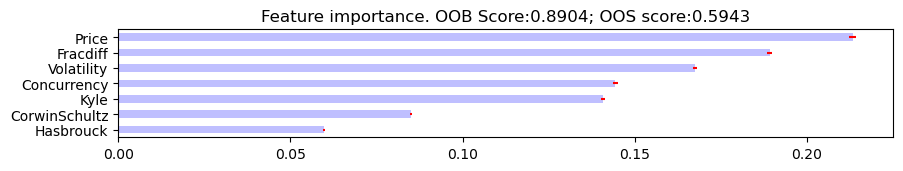

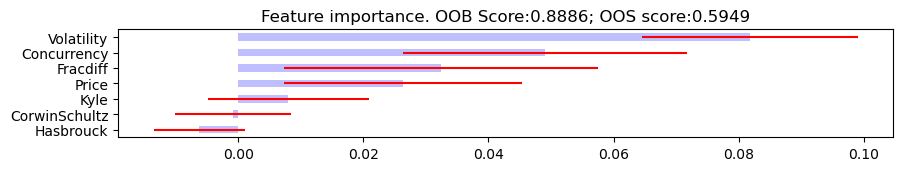

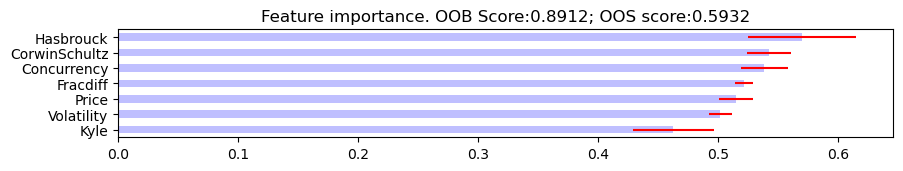

In [39]:
test_data_func(X_train, cont)

#### Machine Learning Score

              precision    recall  f1-score   support

    no trade       0.60      0.38      0.46      4647
       trade       0.51      0.72      0.60      4178

    accuracy                           0.54      8825
   macro avg       0.55      0.55      0.53      8825
weighted avg       0.56      0.54      0.53      8825


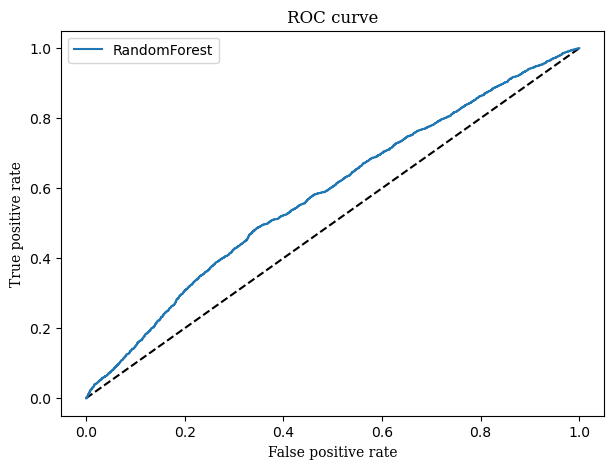

In [40]:
from sklearn.metrics import roc_curve, classification_report

fit = rf.fit(X_train, y_train)
y_pred_rf = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (7,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'RandomForest')
plt.grid(False)
plt.xlabel('False positive rate', fontfamily = 'Serif')
plt.ylabel('True positive rate', fontfamily = 'Serif')
plt.title('ROC curve', fontsize = 12, fontfamily = 'Serif')
plt.legend(loc = 'best')
plt.show()

#### Bet sizing

In [169]:
from FinancialMachineLearning.bet_sizing.bet_sizing import (bet_size_probability, bet_size_dynamic, bet_size_budget, bet_size_reserve, confirm_and_cast_to_df, get_concurrent_sides, cdf_mixture, single_bet_size_mixed, M2N, raw_moment, most_likely_parameters, avg_active_signals)
from FinancialMachineLearning.bet_sizing.ef3m import centered_moment

In [170]:
event_prob = pd.DataFrame()
event_prob['t1'] = triple_barrier_events[-8825:]['t1'].values
event_prob['prob'] = fit.predict_proba(X_test)[:,1]
event_prob.index = triple_barrier_events[-8825:]['t1'].index

In [171]:
event_prob

,t1,prob
2020-09-03 13:30:00,2020-09-04 11:27:01,0.720611
2020-09-03 13:33:51,2020-09-04 13:41:00,0.744431
2020-09-03 13:39:20,2020-09-04 13:41:00,0.740518
2020-09-03 13:45:09,2020-09-04 13:48:15,0.714426
2020-09-03 13:52:55,2020-09-04 13:58:54,0.710046
...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.736359
2023-05-08 15:16:37,2023-05-09 15:24:47,0.716778
2023-05-08 15:36:39,2023-05-09 15:40:39,0.709600
2023-05-08 15:47:11,2023-05-09 15:48:38,0.720279


In [172]:
event_prob['side'] = 1

In [173]:
event_prob['bet_size_prob'] = bet_size_probability(events = event_prob, 
                                                   prob = event_prob['prob'], 
                                                   num_classes = 2)

In [174]:
event_prob

,t1,prob,side,bet_size_prob
2020-09-03 13:30:00,2020-09-04 11:27:01,0.720611,1,0.377045
2020-09-03 13:33:51,2020-09-04 13:41:00,0.744431,1,0.424785
2020-09-03 13:39:20,2020-09-04 13:41:00,0.740518,1,0.416781
2020-09-03 13:45:09,2020-09-04 13:48:15,0.714426,1,0.365016
2020-09-03 13:52:55,2020-09-04 13:58:54,0.710046,1,0.356579
...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.736359,1,0.408346
2023-05-08 15:16:37,2023-05-09 15:24:47,0.716778,1,0.369574
2023-05-08 15:36:39,2023-05-09 15:40:39,0.709600,1,0.355724
2023-05-08 15:47:11,2023-05-09 15:48:38,0.720279,1,0.376397


In [175]:
from multiprocessing import cpu_count

avg_active_bet_sizes = avg_active_signals(event_prob.rename(columns ={'bet_size_prob': 'signal'}), num_threads = cpu_count())
event_prob['avg_active_bet_size'] = avg_active_bet_sizes

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit f

In [176]:
print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(event_prob)
print("Summary statistics on the bet size columns:")
display(event_prob[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

The first 10 rows of the resulting DataFrame from Exercise 10.2:


,t1,prob,side,bet_size_prob,avg_active_bet_size
2020-09-03 13:30:00,2020-09-04 11:27:01,0.720611,1,0.377045,0.377045
2020-09-03 13:33:51,2020-09-04 13:41:00,0.744431,1,0.424785,0.400915
2020-09-03 13:39:20,2020-09-04 13:41:00,0.740518,1,0.416781,0.406204
2020-09-03 13:45:09,2020-09-04 13:48:15,0.714426,1,0.365016,0.395907
2020-09-03 13:52:55,2020-09-04 13:58:54,0.710046,1,0.356579,0.388041
...,...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.736359,1,0.408346,0.186849
2023-05-08 15:16:37,2023-05-09 15:24:47,0.716778,1,0.369574,0.194793
2023-05-08 15:36:39,2023-05-09 15:40:39,0.709600,1,0.355724,0.201499
2023-05-08 15:47:11,2023-05-09 15:48:38,0.720279,1,0.376397,0.208495


Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,8825.000000,8825.000000,8825.000000
mean,0.588851,0.154685,0.167681
std,0.150263,0.256615,0.203416
min,0.265507,-0.404584,-0.338445
25%,0.448892,-0.081842,0.011270
50%,0.621093,0.197116,0.199397
75%,0.734814,0.405231,0.354354
max,0.790592,0.524886,0.486862


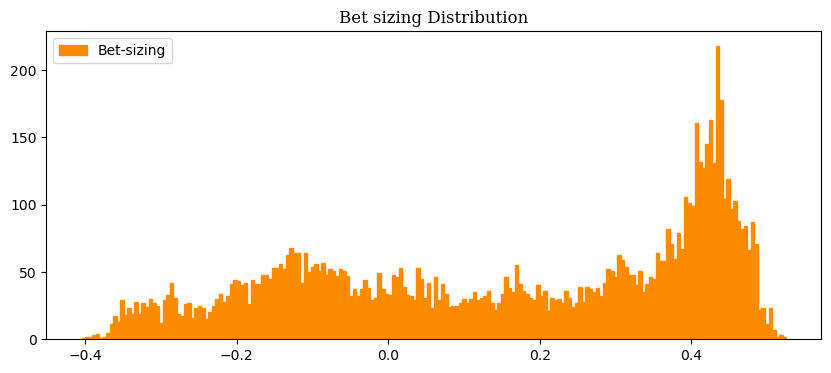

In [177]:
plt.figure(figsize = (10, 4))
plt.hist(event_prob.bet_size_prob, bins = 200, color = 'darkorange', edgecolor = 'darkorange', label = 'Bet-sizing')
plt.legend()
plt.title('Bet sizing Distribution', fontsize = 12, fontfamily = 'Serif')
plt.show()

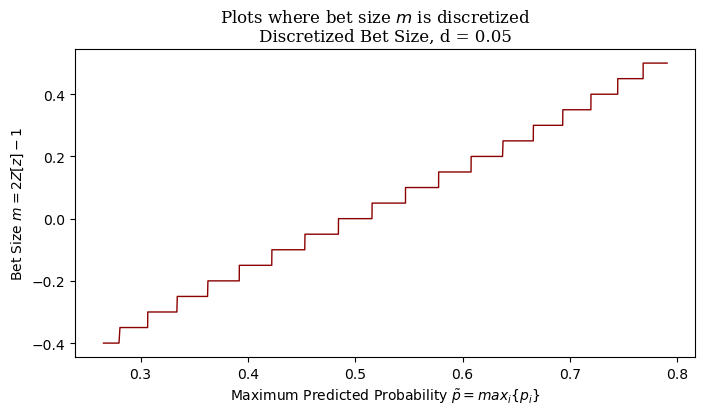

In [197]:
fig, ax = plt.subplots(figsize = (8, 4))

min_prob, max_prob = 1 / 2, 1 
event_prob['bet_size_prob'] = bet_size_probability(events = event_prob, prob = event_prob['prob'], step_size = 0.05, num_classes = 2)
ax.plot(sorted(event_prob['prob']), sorted(event_prob['bet_size_prob']), label=f"||X||={2}", 
           linewidth = 1, alpha = 1, color = 'darkred')

ax.set_ylabel("Bet Size $m=2Z[z]-1$")
ax.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}")
d = 0.05
if not d==0.0:
    ax.set_title(f"Discretized Bet Size, d = {d}", fontsize=12, fontfamily = 'Serif')
else:
    ax.set_title(f"Continuous Bet Size", fontsize = 12, fontfamily = 'Serif')
ax.grid(False)

fig.suptitle("Plots where bet size $m$ is discretized", fontsize=12, fontfamily = 'Serif')
plt.show()

In [198]:
event_prob

,t1,prob,side,bet_size_prob,avg_active_bet_size
2020-09-03 13:30:00,2020-09-04 11:27:01,0.720611,1,0.40,0.377045
2020-09-03 13:33:51,2020-09-04 13:41:00,0.744431,1,0.40,0.400915
2020-09-03 13:39:20,2020-09-04 13:41:00,0.740518,1,0.40,0.406204
2020-09-03 13:45:09,2020-09-04 13:48:15,0.714426,1,0.35,0.395907
2020-09-03 13:52:55,2020-09-04 13:58:54,0.710046,1,0.35,0.388041
...,...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.736359,1,0.40,0.186849
2023-05-08 15:16:37,2023-05-09 15:24:47,0.716778,1,0.35,0.194793
2023-05-08 15:36:39,2023-05-09 15:40:39,0.709600,1,0.35,0.201499
2023-05-08 15:47:11,2023-05-09 15:48:38,0.720279,1,0.40,0.208495


#### Walking Forward Backtesting

In [194]:
backtest = pd.DataFrame()
backtest['Predict'] = model.predict(X_test)
backtest['Actual'] = y_test.values
backtest['Betting Size'] = event_prob.bet_size_prob.values
backtest['Return'] = np.log(matrix.Price / matrix.Price.shift(1))[-8825:].values
backtest['Backtest'] = event_prob.bet_size_prob.values * backtest['Return'].values 
backtest.index = X_test.index
backtest

,Predict,Actual,Betting Size,Return,Backtest
2020-09-03 13:30:00,1,1,0.40,0.002239,0.000896
2020-09-03 13:33:51,1,0,0.40,-0.003274,-0.001310
2020-09-03 13:39:20,1,0,0.40,-0.000777,-0.000311
2020-09-03 13:45:09,1,0,0.35,0.000950,0.000332
2020-09-03 13:52:55,1,0,0.35,0.000173,0.000060
...,...,...,...,...,...
2023-05-08 15:16:20,1,0,0.40,-0.000340,-0.000136
2023-05-08 15:16:37,1,0,0.35,-0.000436,-0.000153
2023-05-08 15:36:39,1,0,0.35,-0.000131,-0.000046
2023-05-08 15:47:11,1,0,0.40,0.000722,0.000289


Text(0.5, 1.0, 'Becktesting Machine Learning Model(Apple)')

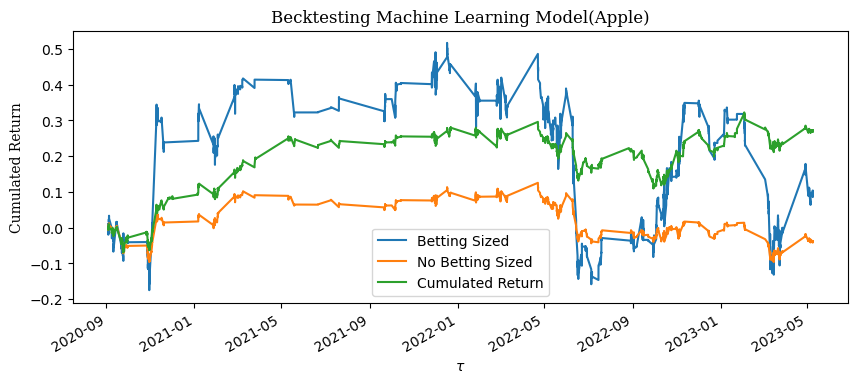

In [195]:
plt.figure(figsize = (10,4))
(backtest[backtest['Predict'] == 1]['Backtest']*10).cumsum().plot(label = 'Betting Sized')
backtest[backtest['Predict'] == 1]['Return'].cumsum().plot(label = 'No Betting Sized')
backtest['Return'].cumsum().plot(label = 'Cumulated Return')
plt.legend()
plt.grid(False)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Cumulated Return', fontfamily = 'Serif')
plt.title('Becktesting Machine Learning Model(Apple)', fontsize = 12, fontfamily = 'Serif')